In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

### DATA LOADING & PREPROCESSING

In [59]:
df = pd.read_csv("tel_churn_.csv")
df.head()

,Unnamed: 0,SeniorCitizen,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_1 - 12,tenure_group_13 - 24,tenure_group_25 - 36,tenure_group_37 - 48,tenure_group_49 - 60,tenure_group_61 - 72
0,0,0,29.85,29.85,0,True,False,False,True,True,...,False,False,True,False,True,False,False,False,False,False
1,1,0,56.95,1889.50,0,False,True,True,False,True,...,False,False,False,True,False,False,True,False,False,False
2,2,0,53.85,108.15,1,False,True,True,False,True,...,False,False,False,True,True,False,False,False,False,False
3,3,0,42.30,1840.75,0,False,True,True,False,True,...,True,False,False,False,False,False,False,True,False,False
4,4,0,70.70,151.65,1,True,False,True,False,True,...,False,False,True,False,True,False,False,False,False,False


In [60]:
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

In [61]:
x = df.drop('Churn', axis=1)
y = df['Churn']

In [62]:
# 1. Split Data
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=100, stratify=y
)
print(f"Original Train Shape: {x_train.shape}")
print(f"Original Test Shape:  {x_test.shape}")

Original Train Shape: (5625, 50)
Original Test Shape:  (1407, 50)


In [63]:
# 2. Apply SMOTE to training data set
smote = SMOTE(random_state=100)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)
print(f"Resampled Train Shape: {x_train_smote.shape}")


Resampled Train Shape: (8260, 50)


In [64]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_smote)
x_test_scaled = scaler.transform(x_test)

In [65]:
def print_report(title, y_true, y_pred):
    print(f"\n" + "="*50)
    print(f" MODEL: {title}")
    print("="*50)
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

### 3. DECISION TREE MODELS

In [66]:
# Decision Tree
dt_base = DecisionTreeClassifier(random_state=100)
dt_base.fit(x_train_smote, y_train_smote)

y_pred_dt_base = dt_base.predict(x_test)
y_prob_dt_base = dt_base.predict_proba(x_test)[:, 1]

print_report("DT: Base (No Tuning)", y_test, y_pred_dt_base)


 MODEL: DT: Base (No Tuning)
Accuracy: 0.7257

Confusion Matrix:
[[827 206]
 [180 194]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1033
           1       0.48      0.52      0.50       374

    accuracy                           0.73      1407
   macro avg       0.65      0.66      0.66      1407
weighted avg       0.73      0.73      0.73      1407



In [67]:
# Decision Tree (Tuned)
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 6, 8, 10, 12],
    'min_samples_leaf': [2, 4, 8],
    'min_samples_split': [2, 5, 10]
}

In [68]:
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=100), param_grid, cv=5, n_jobs=-1, verbose=1)
grid_dt.fit(x_train_smote, y_train_smote)

best_dt = grid_dt.best_estimator_
y_pred_dt_tuned = best_dt.predict(x_test)
y_prob_dt_tuned = best_dt.predict_proba(x_test)[:, 1]

print(f"Best Params: {grid_dt.best_params_}")
print_report("DT: Tuned (GridSearch)", y_test, y_pred_dt_tuned)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}

 MODEL: DT: Tuned (GridSearch)
Accuracy: 0.7697

Confusion Matrix:
[[842 191]
 [133 241]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1033
           1       0.56      0.64      0.60       374

    accuracy                           0.77      1407
   macro avg       0.71      0.73      0.72      1407
weighted avg       0.78      0.77      0.77      1407



### 4. NEURAL NETWORK MODELS

In [69]:
# Neural Network (Base)
nn_base = keras.Sequential([
    layers.Input(shape=(x_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [70]:
nn_base.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn_base.fit(x_train_scaled, y_train_smote, epochs=10, batch_size=32, verbose=0)

y_prob_nn_base = nn_base.predict(x_test_scaled).flatten()
y_pred_nn_base = (y_prob_nn_base > 0.5).astype("int32")

print_report("NN: Base Model", y_test, y_pred_nn_base)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 MODEL: NN: Base Model
Accuracy: 0.7726

Confusion Matrix:
[[890 143]
 [177 197]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      1033
           1       0.58      0.53      0.55       374

    accuracy                           0.77      1407
   macro avg       0.71      0.69      0.70      1407
weighted avg       0.77      0.77      0.77      1407



In [71]:
# Neural Network (Tuned)
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(x_train_scaled.shape[1],)))

    # Tune: Layers, Units, Activation, Dropout
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', 32, 128, step=32),
            activation=hp.Choice('activation', ['relu', 'tanh'])
        ))
        if hp.Boolean('dropout'):
            model.add(layers.Dropout(0.2))

    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [72]:
project_name = f"churn_tuning_{int(time.time())}"

In [73]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name=project_name,
    overwrite=True
)

In [74]:
tuner.search(x_train_scaled, y_train_smote, epochs=10, validation_split=0.2, verbose=1)

Trial 5 Complete [00h 00m 15s]
val_accuracy: 0.9697336554527283

Best val_accuracy So Far: 0.9878934621810913
Total elapsed time: 00h 01m 01s


In [75]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
nn_tuned = tuner.hypermodel.build(best_hps)
nn_tuned.fit(x_train_scaled, y_train_smote, epochs=20, validation_split=0.2, verbose=0)

y_prob_nn_tuned = nn_tuned.predict(x_test_scaled).flatten()
y_pred_nn_tuned = (y_prob_nn_tuned > 0.5).astype("int32")

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [76]:
print_report("NN: Tuned (KerasTuner)", y_test, y_pred_nn_tuned)



 MODEL: NN: Tuned (KerasTuner)
Accuracy: 0.7640

Confusion Matrix:
[[922 111]
 [221 153]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1033
           1       0.58      0.41      0.48       374

    accuracy                           0.76      1407
   macro avg       0.69      0.65      0.66      1407
weighted avg       0.75      0.76      0.75      1407



### 5. COMPARISON & DIFFERENCE REPORT

In [77]:
scores = {
    'DT-Base': accuracy_score(y_test, y_pred_dt_base),
    'DT-Tuned': accuracy_score(y_test, y_pred_dt_tuned),
    'NN-Base': accuracy_score(y_test, y_pred_nn_base),
    'NN-Tuned': accuracy_score(y_test, y_pred_nn_tuned)
}

In [78]:
comparisons = {
    'DT-Tuned vs DT-Base': abs(scores['DT-Tuned'] - scores['DT-Base']),
    'NN-Tuned vs NN-Base': abs(scores['NN-Tuned'] - scores['NN-Base']),
    'DT-Tuned vs NN-Tuned': abs(scores['DT-Tuned'] - scores['NN-Tuned']),
    'DT-Base vs NN-Base': abs(scores['DT-Base'] - scores['NN-Base'])
}

In [79]:
sorted_diffs = sorted(comparisons.items(), key=lambda item: item[1], reverse=True)

In [80]:
print("\nModel Accuracies:")
for model, score in scores.items():
    print(f"  {model}: {score:.4f}")


Model Accuracies:
  DT-Base: 0.7257
  DT-Tuned: 0.7697
  NN-Base: 0.7726
  NN-Tuned: 0.7640


In [81]:
print("\nDifferences (Sorted High to Low):")
for pair, diff in sorted_diffs:
    print(f"  {pair}: {diff:.4f}")


Differences (Sorted High to Low):
  DT-Base vs NN-Base: 0.0469
  DT-Tuned vs DT-Base: 0.0441
  NN-Tuned vs NN-Base: 0.0085
  DT-Tuned vs NN-Tuned: 0.0057


In [82]:
print(f"Max Difference: {sorted_diffs[0][1]:.4f} ({sorted_diffs[0][0]})")
print(f"Min Difference: {sorted_diffs[-1][1]:.4f} ({sorted_diffs[-1][0]})")

Max Difference: 0.0469 (DT-Base vs NN-Base)
Min Difference: 0.0057 (DT-Tuned vs NN-Tuned)


###  6. VISUALIZATION

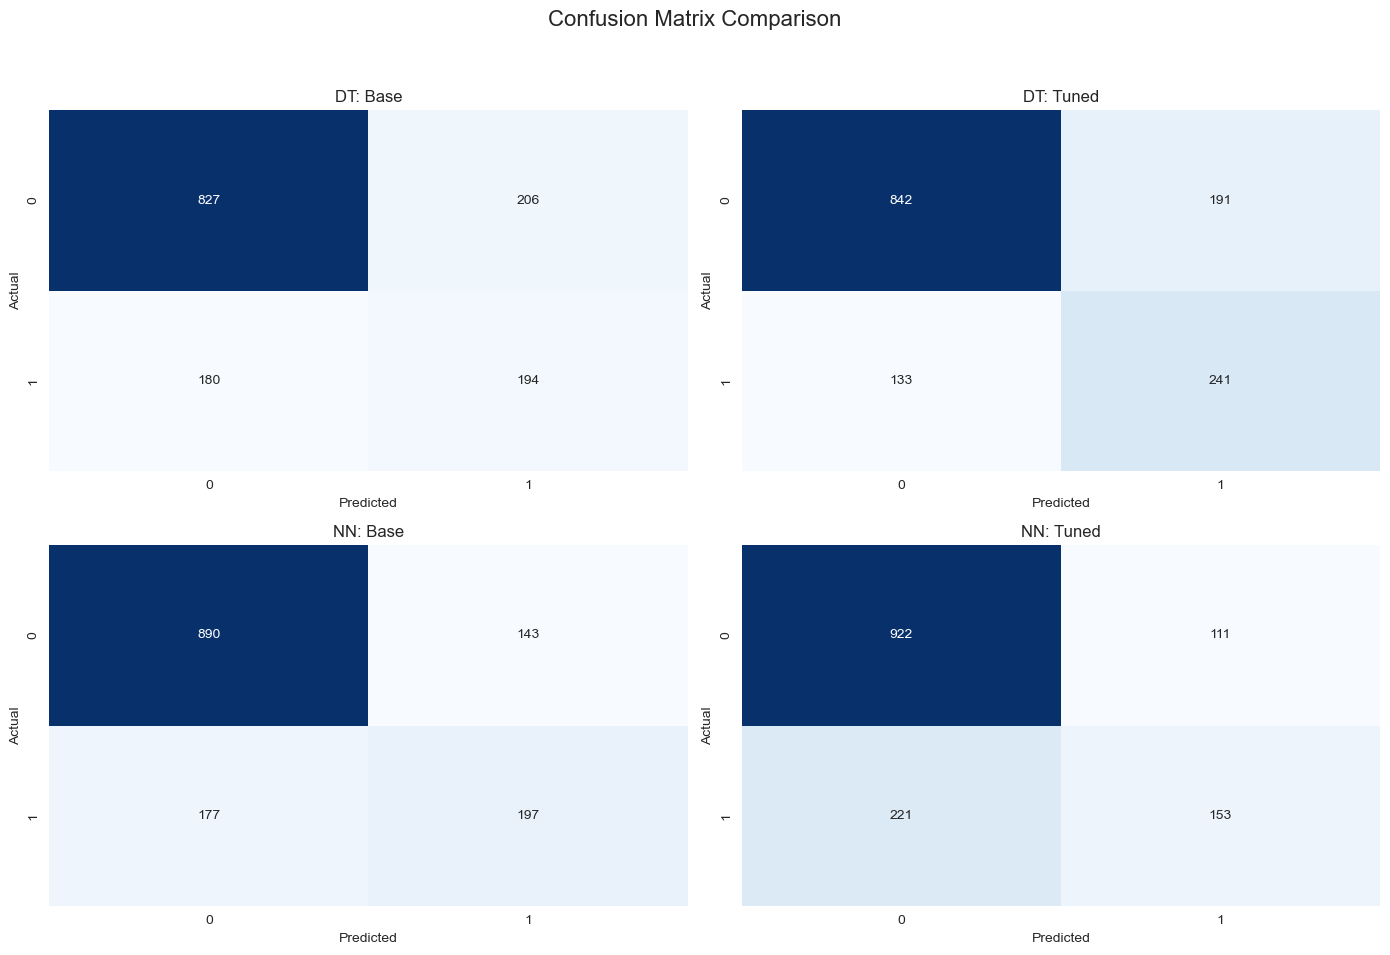

In [83]:
# Confusion Matrices
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Confusion Matrix Comparison', fontsize=16)

def plot_cm(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plot_cm(y_test, y_pred_dt_base, "DT: Base", axes[0, 0])
plot_cm(y_test, y_pred_dt_tuned, "DT: Tuned", axes[0, 1])
plot_cm(y_test, y_pred_nn_base, "NN: Base", axes[1, 0])
plot_cm(y_test, y_pred_nn_tuned, "NN: Tuned", axes[1, 1])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

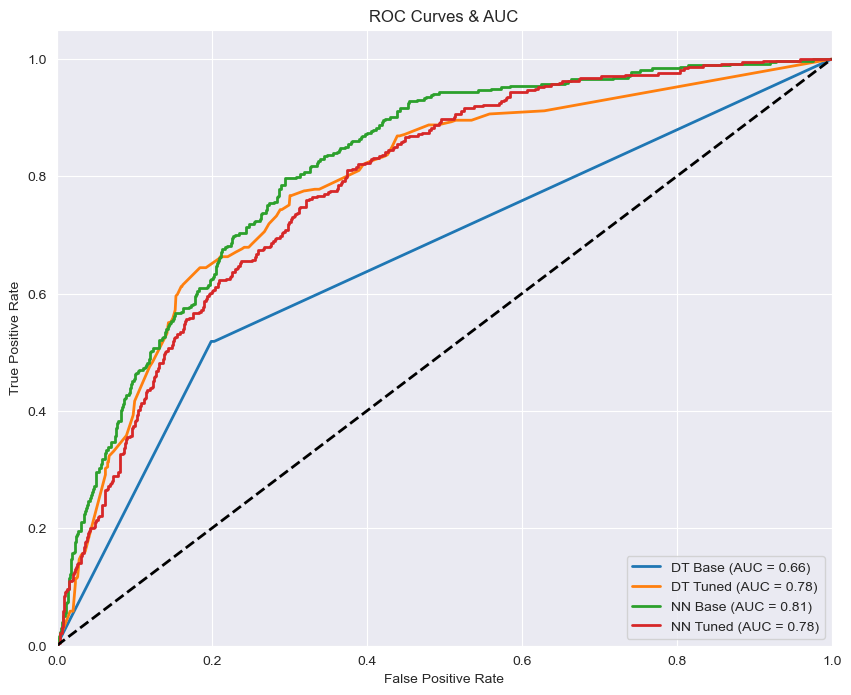

In [84]:
# ROC Curves
plt.figure(figsize=(10, 8))

models_roc = [
    ('DT Base', y_prob_dt_base),
    ('DT Tuned', y_prob_dt_tuned),
    ('NN Base', y_prob_nn_base),
    ('NN Tuned', y_prob_nn_tuned)
]

for name, y_prob in models_roc:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})', lw=2)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves & AUC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()